# Cookie Cats
Cookie Cats - это популярная мобильная головоломка, разработанная компанией Tactile Entertainment. Это классическая головоломка "соедини три", в которой игрок должен соединять плитки одного цвета, чтобы очистить поле и пройти уровень. По мере продвижения игроков через уровни игры они время от времени сталкиваются с закрытой зоной, которая заставляет их ждать продолжительное время или совершить покупку в приложении, чтобы открыть новую игровую зону и продвинуться дальше. Помимо стимулирования покупок в приложении, эти зоны служат важной цели - предоставить игрокам принудительный перерыв от игры, что, в перспективе, должно увеличить и продлить их удовольствие от игры.

In [39]:
import numpy as np                 # Импорт библиотеки NumPy
import pandas as pd                # Импорт библиотеки Pandas
import matplotlib.pyplot as plt    # Импорт библиотеки Matplotlib
%matplotlib inline
# Строка для отображения графиков в текущем ноутбуке.

df = pd.read_csv('/kaggle/input/cokie-cats/cookie_cats.csv')    # Чтение CSV-файла

df.head()                                                       # Отображение нескольких строк датафрейма

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Описание набора данных
У нас есть данные о 90 189 игроках, которые установили игру во время проведения AB-теста. Описание набора данных:

* userid - уникальный номер, который идентифицирует каждого игрока.
* version - указывает, был ли игрок в контрольной группе (gate_30 - зона на 30-м уровне) или в группе с перемещенной зоной (gate_40 - зона на 40-м уровне).
* sum_gamerounds - количество уровней в игре, пройденных игроком в первые 14 дней после установки.
* retention_1 - вернулся ли игрок спустя один день после установки?
* retention_7 - вернулся ли игрок спустя семь дней после установки?

Когда игрок устанавливал игру, он был случайным образом назначен либо в группу с  закрытой зоной на 30-м уровне, либо в группу с  закрытой зоной на 40-м уровне. В качестве проверки корректности данных, давайте посмотрим количество игроков в каждой из A/B-групп.

In [40]:
# Подсчет количества игроков в каждой группе A/B
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

# A/B - тестирование

Похоже, что количество игроков в каждой группе примерно одинаковое.

Основное внимание в этом анализе будет уделено тому, как размещение запретных зон влияет на удержание игроков, но для разнообразия давайте построим график распределения количества уровней в игре, которые игроки прошли/сыграли в первую неделю игры.

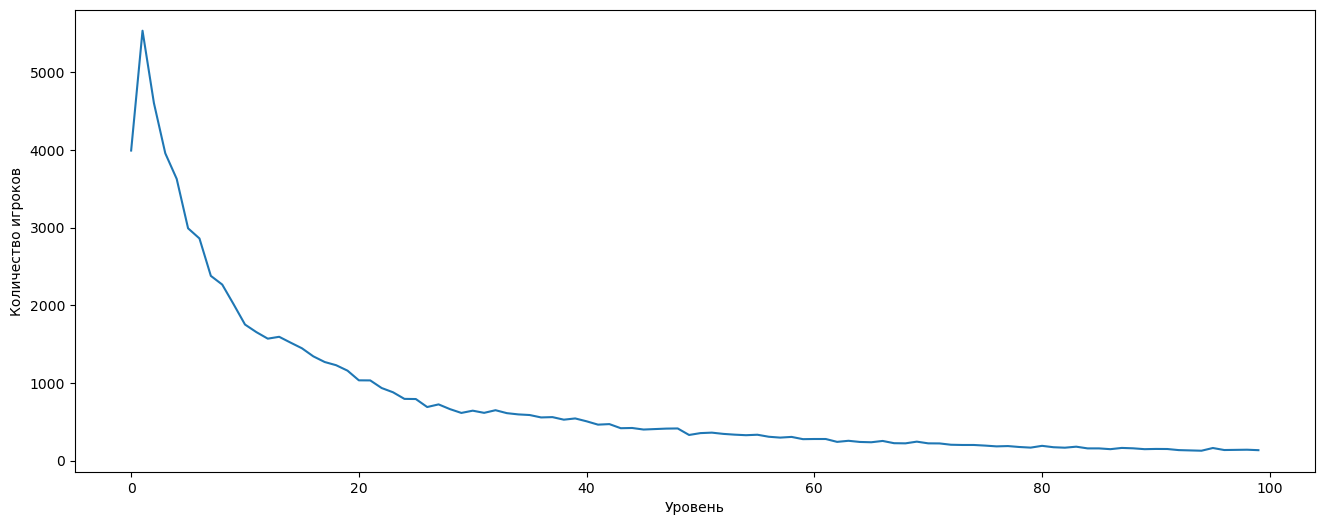

In [41]:
# Подсчет количества игроков для каждого уровня в игре
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Построение графика распределения игроков, сыгравших от 0 до 100 уровней
plt.figure(figsize=(16, 6))
ax = plot_df.head(n=100).plot(x="sum_gamerounds", y="userid")
ax.set_xlabel("Уровень")
ax.set_ylabel("Количество игроков")
plt.show()

На графике выше мы можем видеть, что некоторые игроки устанавливают игру, но затем никогда не играют в нее (0 уровней), некоторые игроки проходят только несколько уровней в первую неделю, а некоторые настолько заинтересованы, что играют достаточно много и проходят множество уровней.

То, что нам нужно, это чтобы игрокам нравилась игра и они становились в нее увлеченными. Общим показателем в индустрии видеоигр для определения увлекательности игры и привлекательности для игроков является удержание на один день: процент игроков, которые возвращаются и играют в игру спустя один день после установки. Чем выше коэффициент удержания после одного дня, тем проще удерживать игроков и создавать большую базу пользователей.

В качестве первого шага давайте посмотрим на общий показатель удержания первого дня.

In [42]:
# Расчет процента пользователей, вернувшихся на следующий день после установки игры
df['retention_1'].sum() / df['retention_1'].count()

0.4452095044850259

Таким образом, немного менее половины игроков (44,5%) возвращаются спустя один день после установки игры. Теперь, когда у нас есть базовый показатель, давайте посмотрим, как удержание на один день отличается между двумя группами A/B.

In [43]:
# Расчет удержания на 1-й день для каждой группы A/B
df.groupby('version')['retention_1'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.448188
gate_40    0.442283
dtype: float64

Похоже, что удержание на один день немного уменьшилось, когда запретная зона была перемещена на уровень 40 (44.2%), по сравнению с контрольной группой, где она находилась на уровне 30 (44.8%). Это небольшое изменение, но даже незначительные изменения в удержании могут иметь большое влияние. Однако, хотя мы уверены в разнице в данных, насколько уверены мы должны быть в том, что зона на уровне 40 будут хуже в будущем?

Существует несколько способов определить степень уверенности в этих показателях удержания. В этой работе будет использоваться метод bootstrap (метод Монте-Карло): мы будем многократно пересэмплировать наш набор данных (с возвращением) и вычислять удержание на один день для этих выборок. Разброс в значениях удержания на один день даст нам представление о том, насколько неопределены эти показатели удержания.

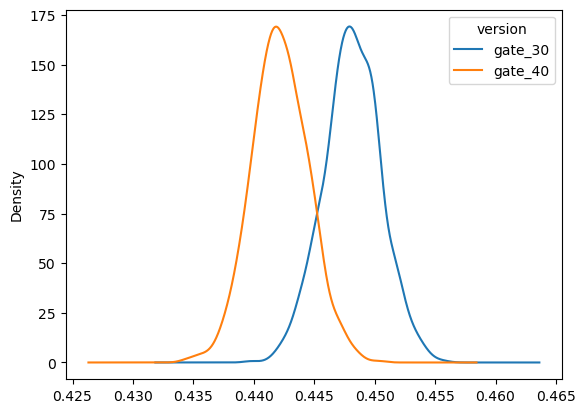

In [44]:
# Создание списка с пересэмплированными средними для каждой группы A/B
boot_1d = []
for _ in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Преобразование списка в DataFrame
boot_1d = pd.DataFrame(boot_1d)

# Построение графика оценки плотности ядра для распределений bootstrap выборок
boot_1d.plot(kind='kde')
plt.show()

Эти два распределения выше представляют неопределенность bootstrap относительно того, каким может быть основное удержание на 1 день для двух групп A/B. Просто взглянув на этот график, мы можем заметить, что есть некоторая разница, хотя и небольшая. Попытаемся найти разницу в удержании на один день.

(Заметьте, что в этой работе мы ограничили количество повторений bootstrap до 1000 для быстрого выполнения вычислений. В "продакшене", вероятно, это число увеличили бы до гораздо большего значения.)

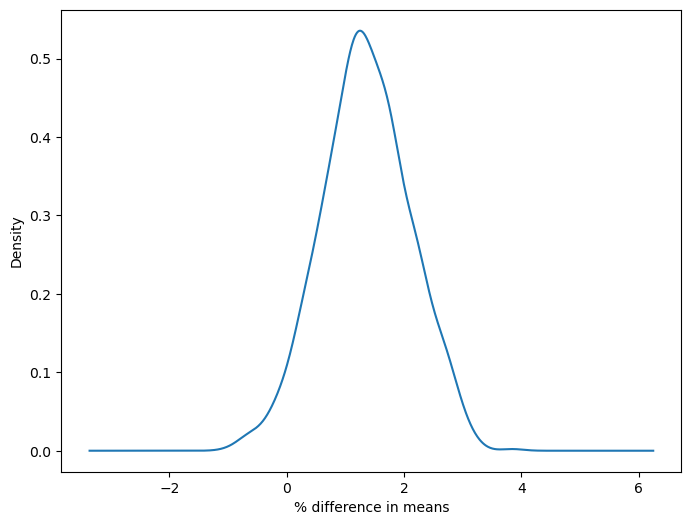

In [45]:
# Добавление столбца с процентным различием между двумя группами A/B
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# Построение графика процентного различия для bootstrap выборок
plt.figure(figsize=(8, 6))
ax = boot_1d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")
plt.show()

Из этого графика мы можем видеть, что наиболее вероятное различие в процентах составляет около 1% - 2%, и большая часть распределения находится выше 0%, в пользу запретной зоны на уровне 30. Но какова вероятность того, что разница будет больше 0%? Вычислим это.

In [46]:
# Расчет вероятности того, что удержание на 1-й день больше, когда запретная зона находятся на уровне 30
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d)

# Форматирования полученного значения
'{:.2%}'.format(prob)

'96.30%'

Анализ bootstrap позволяет нам сделать вывод о высокой вероятности того, что удержание на один день лучше, когда запретная зона находятся на уровне 30 (вероятность ошибки менее 5 %). Однако, так как игроки играют в игру всего один день, вероятно, что большинство из них еще не достигли 30-го уровня. То есть многие игроки не были дошли до закрытой зоны, даже если она расположена на 30-м уровне.

Однако, после того, как игроки играют в игру уже неделю, большинство активных игроков должны достичь 40-го уровня, и поэтому имеет смысл также рассмотреть удержание на семь дней. То есть какой процент людей, установивших игру, вернулся через неделю, чтобы снова поиграть.

Давайте начнем с расчета удержания на семь дней для двух групп AB.


In [47]:
# Расчет удержания на 7-й день для обеих групп A/B
df.groupby('version')['retention_7'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.190201
gate_40    0.182000
dtype: float64

Как и с удержанием на один день, видно, что удержание на семь дней немного ниже (18.2%) при размещении зоны на уровне 40, чем при размещении на уровне 30 (19.0%). Эта разница также больше, чем в удержании на одни день, предположительно потому, что больше игроков успело достигнуть первой запретной зоны. Мы также видим, что общее удержание на семь дней ниже, чем общее удержание на один день; меньше людей играет в игру в течение недели после установки, чем в через день после установки.

Но как и ранее, давайте воспользуемся анализом bootstrap, чтобы определить, насколько можно быть увереными в полученной разнице между группами AB.

'99.70%'

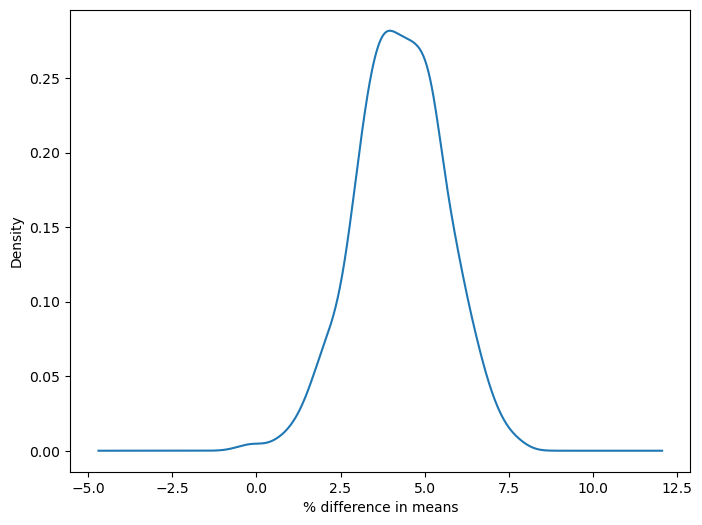

In [51]:
# Создание списка с пересэмплированными средними для каждой группы A/B
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_30'] * 100

plt.figure(figsize=(8, 6))
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)

'{:.2%}'.format(prob)

Результаты анализа bootstrap позволяют сделать вывод о том, что удержание на семь дней выше, когда запретная зона находятся на уровне 30, чем когда она находятся на уровне 40.

# Итоги
В итоге можно утверждать, что если мы хотим сохранить высокое удержание - как на 1-й день, так и на 7-й день - нам не следует перемещать зону с уровня 30 на уровень 40. Конечно, есть и другие метрики, на которые мы можем обратить внимание, такие как количество пройденных уровней в игре или количество внутриигровых покупок в двух группах A/B. Но удержание - одна из самых важных метрик. Если мы не удерживаем нашу базу игроков, то не имеет значения, сколько они тратят денег внутри игры.

Теперь, почему удержание выше, когда запретная зона находятся на более раннем уровне? Можно было бы ожидать обратного: чем позже появляется препятствие, тем дольше люди будут вовлечены в игру. Но именно это не говорят нам данные. Теория гедонистической адаптации может дать объяснение этому явлению. Вкратце, гедонистическая адаптация - это тенденция людей получать все меньше удовольствия от приятной активности со временем, если они постоянно ее выполняют. Заставляя игроков делать перерыв, когда они достигают закрытой зоны, можно продлить их удовольствие от игры. Но когда зона перемещается на уровень 40, меньше игроков достигает этого уровня, и следовательно повышается шанс бросить игру просто потому, что им она надоела.